Initializing CUDA...
CUDA initialization complete
Loading library: ./cuda_matlib.so
Function signatures configured
Initializing CUDA resources (one-time operation)...
CUDA resources initialized

=== Testing batch size: 1 ===
Initializing model with hidden_size=768
Generating 5 tokens per sequence with tensor cores...


Generating tokens (batch=1): 100%|██████████| 5/5 [00:00<00:00, 39.23it/s]


Generating 5 tokens per sequence without tensor cores...


Generating tokens (batch=1): 100%|██████████| 5/5 [00:00<00:00, 20.03it/s]


Results for batch_size=1:
  Total tokens generated: 5
  Tensor Cores: 39.44 tokens/sec
  Standard: 20.13 tokens/sec
  Speedup: 1.96x

=== Testing batch size: 2 ===
Initializing model with hidden_size=768
Generating 5 tokens per sequence with tensor cores...


Generating tokens (batch=2): 100%|██████████| 5/5 [00:00<00:00, 59.63it/s]


Generating 5 tokens per sequence without tensor cores...


Generating tokens (batch=2): 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]


Results for batch_size=2:
  Total tokens generated: 10
  Tensor Cores: 119.44 tokens/sec
  Standard: 22.47 tokens/sec
  Speedup: 5.32x
  Throughput scaling: 3.03x vs batch_size=1
  Scaling efficiency: 151.4%

=== Testing batch size: 4 ===
Initializing model with hidden_size=768
Generating 5 tokens per sequence with tensor cores...


Generating tokens (batch=4): 100%|██████████| 5/5 [00:00<00:00, 43.36it/s]


Generating 5 tokens per sequence without tensor cores...


Generating tokens (batch=4): 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Results for batch_size=4:
  Total tokens generated: 20
  Tensor Cores: 174.16 tokens/sec
  Standard: 25.32 tokens/sec
  Speedup: 6.88x
  Throughput scaling: 4.42x vs batch_size=1
  Scaling efficiency: 110.4%

=== Testing batch size: 8 ===
Initializing model with hidden_size=768
Generating 5 tokens per sequence with tensor cores...


Generating tokens (batch=8): 100%|██████████| 5/5 [00:00<00:00, 27.34it/s]


Generating 5 tokens per sequence without tensor cores...


Generating tokens (batch=8): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Results for batch_size=8:
  Total tokens generated: 40
  Tensor Cores: 219.48 tokens/sec
  Standard: 24.93 tokens/sec
  Speedup: 8.80x
  Throughput scaling: 5.56x vs batch_size=1
  Scaling efficiency: 69.6%

=== Testing batch size: 16 ===
Initializing model with hidden_size=768
Generating 5 tokens per sequence with tensor cores...


Generating tokens (batch=16): 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


Generating 5 tokens per sequence without tensor cores...


Generating tokens (batch=16): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Results for batch_size=16:
  Total tokens generated: 80
  Tensor Cores: 244.32 tokens/sec
  Standard: 25.22 tokens/sec
  Speedup: 9.69x
  Throughput scaling: 6.19x vs batch_size=1
  Scaling efficiency: 38.7%

=== Testing batch size: 32 ===
Initializing model with hidden_size=768
Generating 5 tokens per sequence with tensor cores...


Generating tokens (batch=32):  20%|██        | 1/5 [00:00<00:01,  3.43it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_669793/3678741582.py", line 339, in benchmark_batch_scaling
    tensor_result = self.forward(input_ids, seq_length-1, gen_tokens)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_669793/3678741582.py", line 161, in forward
    attention_output = self._optimized_self_attention_block(current_hidden)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_669793/3678741582.py", line 255, in _optimized_self_attention_block
    flat_output = self.tensor_ops.matmul(flat_attn_output, self.out_proj)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/home/fraser/Documents/NAS/Drive/local/machine learning/fortran/examples/collected_examples/matrix_dot/tensor11/tensor_matrix_ops.py", line 232, in matmul
    a_f = cp.asfortranarray(a, dtype=cp.f

Error with batch size 32: Out of memory allocating 201,523,200 bytes (allocated so far: 2,437,742,592 bytes).


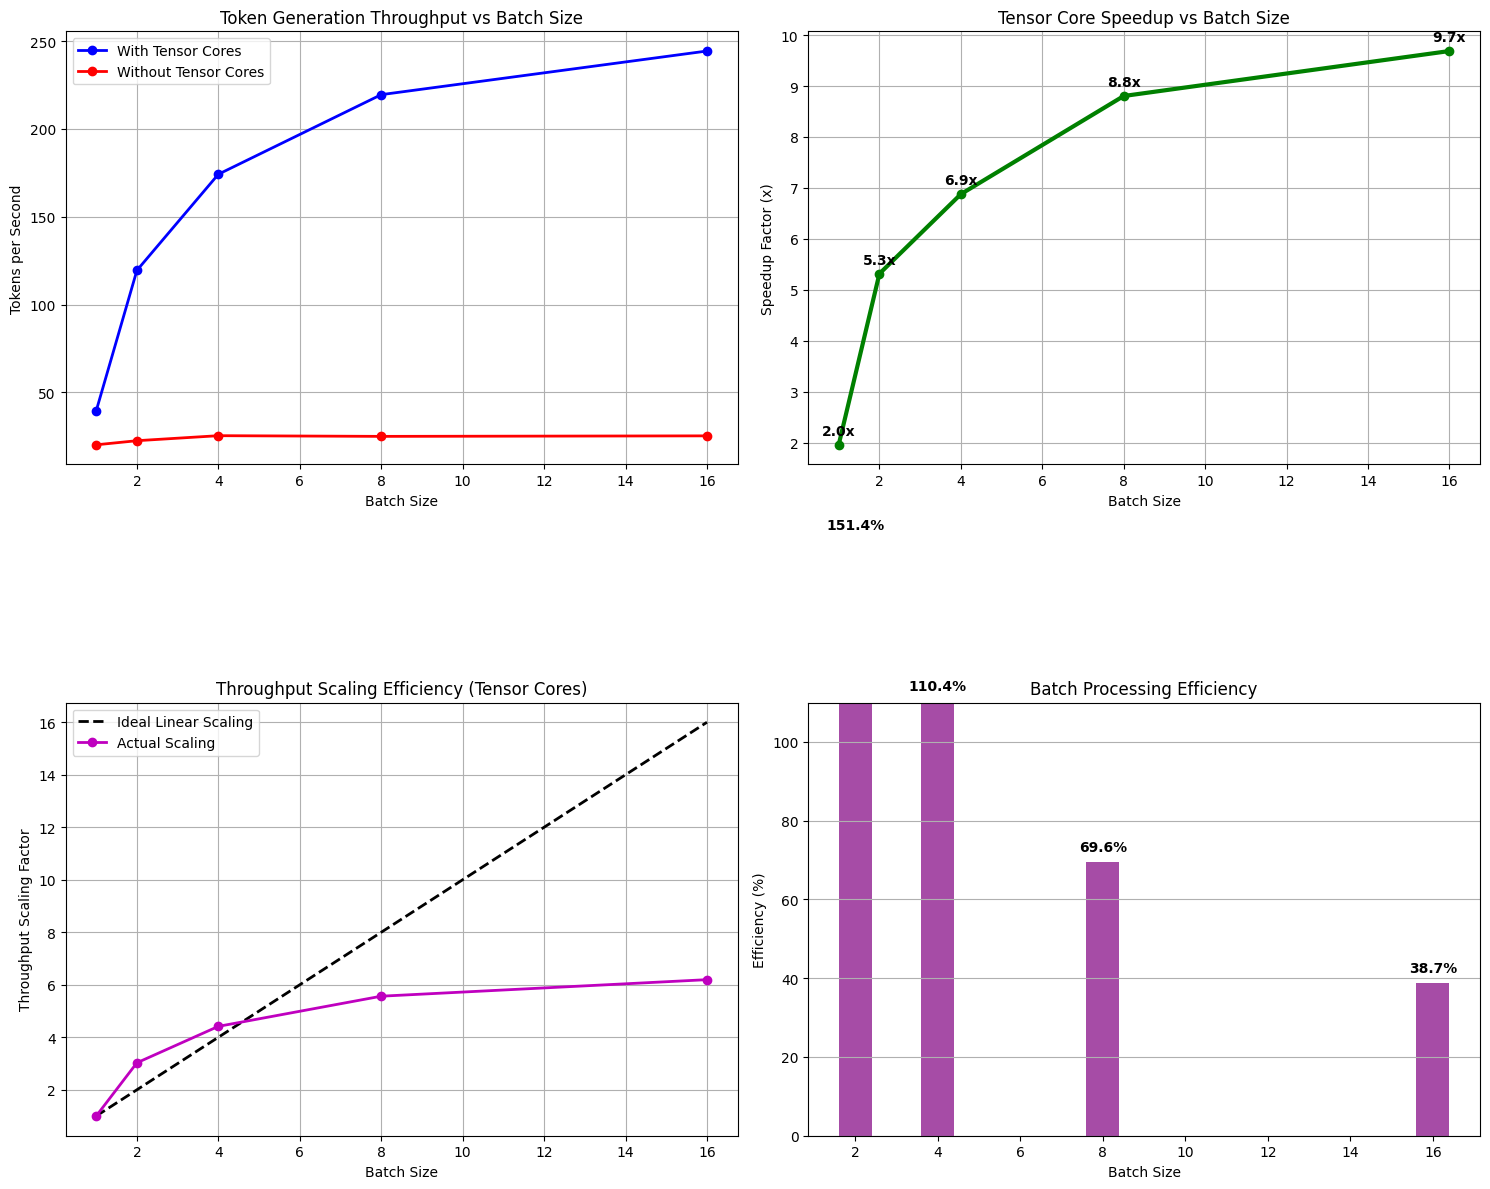

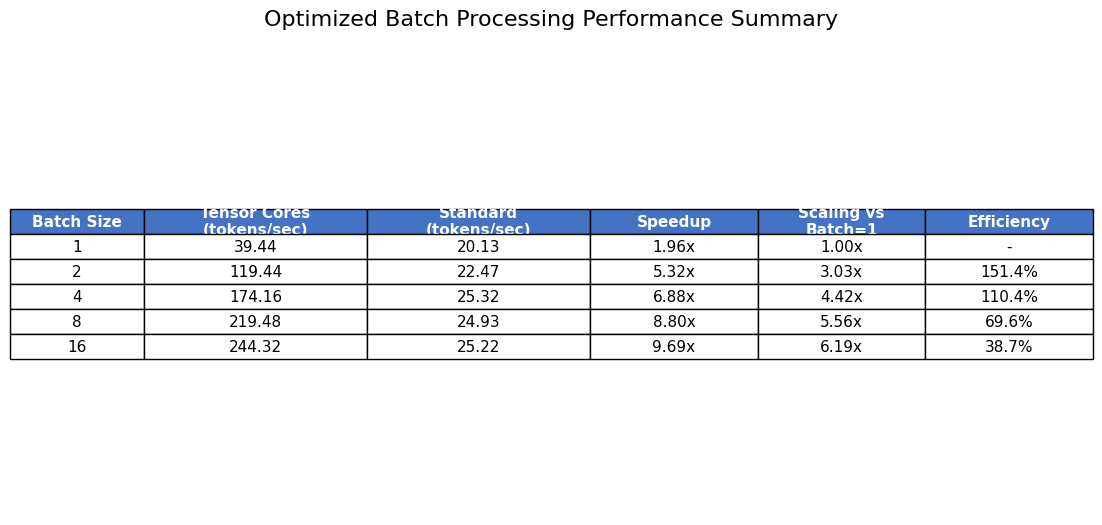


Final Summary:
Batch Size 1: 1.96x speedup, 39.44 tokens/sec
Batch Size 2: 5.32x speedup, 119.44 tokens/sec
  → 3.03x throughput vs batch=1 (151.4% efficiency)
Batch Size 4: 6.88x speedup, 174.16 tokens/sec
  → 4.42x throughput vs batch=1 (110.4% efficiency)
Batch Size 8: 8.80x speedup, 219.48 tokens/sec
  → 5.56x throughput vs batch=1 (69.6% efficiency)
Batch Size 16: 9.69x speedup, 244.32 tokens/sec
  → 6.19x throughput vs batch=1 (38.7% efficiency)


In [1]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensor_matrix_ops import TensorMatrixOps

class OptimizedBatchedInferenceDemo:
    """Demonstration of tensor cores impact on batched token generation using true batched matmul."""
    
    def __init__(self, use_tensor_cores=True):
        """Initialize the demo with or without tensor cores."""
        self.use_tensor_cores = use_tensor_cores
        self.tensor_ops = TensorMatrixOps()
    
    def _matmul(self, a, b):
        """Standard matrix multiplication with or without tensor cores."""
        if self.use_tensor_cores:
            return self.tensor_ops.matmul(a, b)
        else:
            return cp.matmul(a, b)
    
    def _batched_matmul(self, a, b):
        """Batched matrix multiplication with or without tensor cores.
        
        Args:
            a: Input tensor with shape (..., m, k)
            b: Weight tensor with shape (k, n)
            
        Returns:
            Output tensor with shape (..., m, n)
        """
        if self.use_tensor_cores:
            # Reshape input for batched matmul
            original_shape = a.shape
            batch_dims = original_shape[:-2]
            m, k = original_shape[-2:]
            
            # Reshape to (batch_size, m, k) for batched_matmul
            batch_size = np.prod(batch_dims)
            reshaped_a = a.reshape(batch_size, m, k)
            
            # Use batched matmul from tensor_ops
            result = self.tensor_ops.batched_matmul(reshaped_a, b)
            
            # Reshape back to original batch dimensions
            return result.reshape(*batch_dims, m, b.shape[1])
        else:
            # Use standard matmul with broadcasting
            return cp.matmul(a, b)
    
    def _gelu(self, x):
        """Approximate GELU activation function."""
        return 0.5 * x * (1 + cp.tanh(cp.sqrt(2 / np.pi) * (x + 0.044715 * cp.power(x, 3))))
    
    def _softmax(self, x, axis=-1):
        """Compute softmax along specified axis."""
        x_max = cp.max(x, axis=axis, keepdims=True)
        exp_x = cp.exp(x - x_max)
        return exp_x / cp.sum(exp_x, axis=axis, keepdims=True)
    
    def _layer_norm(self, x, gamma, beta, eps=1e-5):
        """Apply layer normalization."""
        mean = cp.mean(x, axis=-1, keepdims=True)
        var = cp.var(x, axis=-1, keepdims=True)
        return gamma * (x - mean) / cp.sqrt(var + eps) + beta
    
    def initialize_model(self, hidden_size=512, num_heads=8, 
                         intermediate_size=2048, vocab_size=50000):
        """Initialize a simple transformer model for token generation."""
        # Store model dimensions
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        self.intermediate_size = intermediate_size
        self.vocab_size = vocab_size
        
        # Initialize weights with appropriate scaling
        scale = 0.02
        
        # Embedding weights
        self.embedding = cp.random.normal(0, scale, (vocab_size, hidden_size)).astype(cp.float64)
        
        # Self-attention weights
        self.query = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.key = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.value = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.out_proj = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        
        # Feed-forward weights
        self.ff1 = cp.random.normal(0, scale, (hidden_size, intermediate_size)).astype(cp.float64)
        self.ff2 = cp.random.normal(0, scale, (intermediate_size, hidden_size)).astype(cp.float64)
        
        # Layer norm weights
        self.ln1_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln1_beta = cp.zeros(hidden_size, dtype=cp.float64)
        self.ln2_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln2_beta = cp.zeros(hidden_size, dtype=cp.float64)
        self.ln_f_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln_f_beta = cp.zeros(hidden_size, dtype=cp.float64)
        
        # Output projection
        self.lm_head = cp.random.normal(0, scale, (hidden_size, vocab_size)).astype(cp.float64)
    
    def cleanup_model(self):
        """Release GPU memory."""
        # Delete all model parameters
        del self.embedding
        del self.query, self.key, self.value, self.out_proj
        del self.ff1, self.ff2
        del self.ln1_gamma, self.ln1_beta
        del self.ln2_gamma, self.ln2_beta
        del self.ln_f_gamma, self.ln_f_beta
        del self.lm_head
        
        # Force memory cleanup
        cp.get_default_memory_pool().free_all_blocks()
    
    def forward(self, input_ids, position=0, max_tokens=10):
        """Generate tokens with the model using optimized batched operations.
        
        Args:
            input_ids: Input token ids [batch_size, seq_len]
            position: Starting position for generation
            max_tokens: Maximum number of tokens to generate
            
        Returns:
            Generated token ids and timing information
        """
        batch_size, seq_len = input_ids.shape
        token_times = []
        
        # Initial embedding lookup - process entire batch at once
        # Create empty hidden states tensor
        hidden_states = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        
        # Efficiently populate embeddings for all tokens in batch
        valid_mask = (input_ids < self.vocab_size)
        for b in range(batch_size):
            for s in range(seq_len):
                if valid_mask[b, s]:
                    hidden_states[b, s] = self.embedding[input_ids[b, s]]
        
        # Context encoding with tqdm progress bar for visualization
        for i in tqdm(range(max_tokens), desc=f"Generating tokens (batch={batch_size})"):
            start_time = time.time()
            
            # Only compute for the current position
            pos = position + i
            if pos >= hidden_states.shape[1]:
                # Extend hidden states if needed
                hidden_states = cp.concatenate([
                    hidden_states, 
                    cp.zeros((batch_size, 1, self.hidden_size), dtype=cp.float64)
                ], axis=1)
            
            # Get hidden state for current position
            current_hidden = hidden_states[:, :pos+1]  # Include all previous tokens for attention
            
            # Self-attention with optimized batched operations
            attention_output = self._optimized_self_attention_block(current_hidden)
            
            # Get only the last position output
            last_hidden = attention_output[:, -1:, :]
            
            # Feed-forward with optimized batched operations
            ffn_output = self._optimized_feed_forward_block(last_hidden)
            
            # Final layer norm
            normed_output = self._layer_norm(ffn_output, self.ln_f_gamma, self.ln_f_beta)
            
            # Language model head for all sequences at once
            # Reshape for efficient batched matrix multiply
            flat_output = normed_output.reshape(-1, self.hidden_size)
            
            # Get logits for all sequences at once
            if self.use_tensor_cores:
                logits = self.tensor_ops.matmul(flat_output, self.lm_head)
            else:
                logits = cp.matmul(flat_output, self.lm_head)
            
            # Reshape logits back to batch format
            logits = logits.reshape(batch_size, -1, self.vocab_size)
            
            # Get most probable next token for each sequence (greedy decoding)
            next_tokens = cp.argmax(logits[:, 0, :], axis=1).get()
            
            # Store new token embeddings for all sequences at once
            if pos + 1 < hidden_states.shape[1]:
                for b in range(batch_size):
                    hidden_states[b, pos+1] = self.embedding[next_tokens[b]]
            
            # Record timing - this measures one token generation across the entire batch
            token_time = time.time() - start_time
            token_times.append(token_time)
        
        # Calculate tokens per second - multiply by batch size since we generate batch_size tokens per step
        total_time = sum(token_times)
        tokens_per_second = (max_tokens * batch_size) / total_time
        
        return {
            'times': token_times,
            'total_time': total_time,
            'tokens_per_second': tokens_per_second,
            'total_tokens': max_tokens * batch_size
        }
    
    def _optimized_self_attention_block(self, hidden_states):
        """Process a self-attention block with optimized batched operations."""
        batch_size, seq_len, hidden_dim = hidden_states.shape
        
        # Layer norm
        normed_hidden = self._layer_norm(hidden_states, self.ln1_gamma, self.ln1_beta)
        
        # Project to q, k, v using batched operations
        # Reshape for batched matmul: [batch_size*seq_len, hidden_size]
        flat_hidden = normed_hidden.reshape(-1, hidden_dim)
        
        # Use batched projection for Q, K, V
        if self.use_tensor_cores:
            flat_q = self.tensor_ops.matmul(flat_hidden, self.query)
            flat_k = self.tensor_ops.matmul(flat_hidden, self.key)
            flat_v = self.tensor_ops.matmul(flat_hidden, self.value)
        else:
            flat_q = cp.matmul(flat_hidden, self.query)
            flat_k = cp.matmul(flat_hidden, self.key)
            flat_v = cp.matmul(flat_hidden, self.value)
        
        # Reshape back to batch format: [batch_size, seq_len, hidden_size]
        q = flat_q.reshape(batch_size, seq_len, hidden_dim)
        k = flat_k.reshape(batch_size, seq_len, hidden_dim)
        v = flat_v.reshape(batch_size, seq_len, hidden_dim)
        
        # Compute attention scores and apply attention weights for each batch item
        # (still need separate processing for attention scores calculation)
        attn_output = cp.zeros_like(hidden_states)
        
        for b in range(batch_size):
            # (seq_len, seq_len)
            attn_scores = self._matmul(q[b], k[b].T) / cp.sqrt(self.head_size)
            
            # Apply causal mask (autoregressive generation)
            mask = cp.tril(cp.ones((seq_len, seq_len), dtype=cp.float64))
            attn_scores = cp.where(mask == 0, -1e10, attn_scores)
            
            # Apply softmax
            attn_probs = self._softmax(attn_scores, axis=-1)
            
            # Apply attention weights
            attn_output[b] = self._matmul(attn_probs, v[b])
        
        # Output projection using batched operations
        flat_attn_output = attn_output.reshape(-1, hidden_dim)
        if self.use_tensor_cores:
            flat_output = self.tensor_ops.matmul(flat_attn_output, self.out_proj)
        else:
            flat_output = cp.matmul(flat_attn_output, self.out_proj)
        
        # Reshape back
        output = flat_output.reshape(batch_size, seq_len, hidden_dim)
        
        # Residual connection
        return hidden_states + output
    
    def _optimized_feed_forward_block(self, hidden_states):
        """Process a feed-forward block with optimized batched operations."""
        batch_size, seq_len, hidden_dim = hidden_states.shape
        
        # Layer norm
        normed_hidden = self._layer_norm(hidden_states, self.ln2_gamma, self.ln2_beta)
        
        # First linear layer using batched operations
        # Reshape for batched matmul: [batch_size*seq_len, hidden_size]
        flat_hidden = normed_hidden.reshape(-1, hidden_dim)
        
        # Use batched matmul
        if self.use_tensor_cores:
            flat_intermediate = self.tensor_ops.matmul(flat_hidden, self.ff1)
        else:
            flat_intermediate = cp.matmul(flat_hidden, self.ff1)
        
        # Reshape to 3D: [batch_size, seq_len, intermediate_size]
        intermediate = flat_intermediate.reshape(batch_size, seq_len, self.intermediate_size)
        
        # Apply GELU activation
        intermediate = self._gelu(intermediate)
        
        # Second linear layer using batched operations
        # Reshape for batched matmul: [batch_size*seq_len, intermediate_size]
        flat_intermediate = intermediate.reshape(-1, self.intermediate_size)
        
        # Use batched matmul
        if self.use_tensor_cores:
            flat_output = self.tensor_ops.matmul(flat_intermediate, self.ff2)
        else:
            flat_output = cp.matmul(flat_intermediate, self.ff2)
        
        # Reshape back to 3D: [batch_size, seq_len, hidden_size]
        output = flat_output.reshape(batch_size, seq_len, hidden_dim)
        
        # Residual connection
        return hidden_states + output
    
    def benchmark_batch_scaling(self, batch_sizes=[1, 2, 4, 8, 16, 32, 64], 
                              seq_length=1024, gen_tokens=5, hidden_size=768):
        """Benchmark how token generation throughput scales with batch size.
        
        Args:
            batch_sizes: List of batch sizes to test
            seq_length: Length of input sequences
            gen_tokens: Number of tokens to generate per sequence
            hidden_size: Model hidden size
            
        Returns:
            Results for each batch size
        """
        results = {
            'tensor': {},
            'standard': {},
            'speedup': {},
            'throughput_scaling': {}
        }
        
        # Test each batch size
        for batch_size in batch_sizes:
            print(f"\n=== Testing batch size: {batch_size} ===")
            
            try:
                # Initialize model
                print(f"Initializing model with hidden_size={hidden_size}")
                self.initialize_model(hidden_size=hidden_size)
                
                # Create random input - all sequences are the same length
                input_ids = cp.random.randint(0, self.vocab_size, (batch_size, seq_length))
                
                # Generate with tensor cores
                self.use_tensor_cores = True
                print(f"Generating {gen_tokens} tokens per sequence with tensor cores...")
                tensor_result = self.forward(input_ids, seq_length-1, gen_tokens)
                tensor_tokens_per_sec = tensor_result['tokens_per_second']
                
                # Generate without tensor cores
                self.use_tensor_cores = False
                print(f"Generating {gen_tokens} tokens per sequence without tensor cores...")
                standard_result = self.forward(input_ids, seq_length-1, gen_tokens)
                standard_tokens_per_sec = standard_result['tokens_per_second']
                
                # Calculate speedup
                speedup = tensor_tokens_per_sec / standard_tokens_per_sec
                
                # Calculate scaling compared to batch size 1
                if batch_size == 1:
                    base_tensor_throughput = tensor_tokens_per_sec
                    throughput_scaling = 1.0
                else:
                    throughput_scaling = tensor_tokens_per_sec / base_tensor_throughput
                
                # Store results
                results['tensor'][batch_size] = tensor_tokens_per_sec
                results['standard'][batch_size] = standard_tokens_per_sec
                results['speedup'][batch_size] = speedup
                results['throughput_scaling'][batch_size] = throughput_scaling
                
                # Print results
                print(f"Results for batch_size={batch_size}:")
                print(f"  Total tokens generated: {tensor_result['total_tokens']}")
                print(f"  Tensor Cores: {tensor_tokens_per_sec:.2f} tokens/sec")
                print(f"  Standard: {standard_tokens_per_sec:.2f} tokens/sec")
                print(f"  Speedup: {speedup:.2f}x")
                if batch_size > 1:
                    print(f"  Throughput scaling: {throughput_scaling:.2f}x vs batch_size=1")
                    print(f"  Scaling efficiency: {throughput_scaling/batch_size*100:.1f}%")
                
            except Exception as e:
                print(f"Error with batch size {batch_size}: {e}")
                import traceback
                traceback.print_exc()
                results['tensor'][batch_size] = None
                results['standard'][batch_size] = None
                results['speedup'][batch_size] = None
                results['throughput_scaling'][batch_size] = None
            
            # Clean up model and release memory
            self.cleanup_model()
        
        # Plot results
        self.plot_batch_scaling_results(results, batch_sizes)
        
        return results
    
    def plot_batch_scaling_results(self, results, batch_sizes):
        """Plot token generation batch scaling results.
        
        Args:
            results: Dictionary with results from benchmark_batch_scaling
            batch_sizes: List of batch sizes tested
        """
        # Filter out any batch sizes that failed
        valid_batch_sizes = [bs for bs in batch_sizes if results['speedup'][bs] is not None]
        
        # Create data for plotting
        tensor_tokens_per_sec = [results['tensor'][bs] for bs in valid_batch_sizes]
        standard_tokens_per_sec = [results['standard'][bs] for bs in valid_batch_sizes]
        speedups = [results['speedup'][bs] for bs in valid_batch_sizes]
        
        # Calculate efficient scaling
        ideal_scaling = [bs for bs in valid_batch_sizes]
        throughput_scaling = [results['throughput_scaling'][bs] for bs in valid_batch_sizes]
        
        # Create figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot tokens per second
        ax = axes[0, 0]
        ax.plot(valid_batch_sizes, tensor_tokens_per_sec, 'b-o', linewidth=2, label='With Tensor Cores')
        ax.plot(valid_batch_sizes, standard_tokens_per_sec, 'r-o', linewidth=2, label='Without Tensor Cores')
        ax.set_title('Token Generation Throughput vs Batch Size')
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Tokens per Second')
        ax.grid(True)
        ax.legend()
        
        # Plot speedup
        ax = axes[0, 1]
        ax.plot(valid_batch_sizes, speedups, 'g-o', linewidth=3)
        ax.set_title('Tensor Core Speedup vs Batch Size')
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Speedup Factor (x)')
        ax.grid(True)
        
        # Add speedup values as text labels
        for i, bs in enumerate(valid_batch_sizes):
            ax.text(bs, speedups[i] + 0.2, f"{speedups[i]:.1f}x", 
                     ha='center', fontweight='bold')
        
        # Plot scaling efficiency
        ax = axes[1, 0]
        ax.plot(valid_batch_sizes, ideal_scaling, 'k--', linewidth=2, label='Ideal Linear Scaling')
        ax.plot(valid_batch_sizes, throughput_scaling, 'm-o', linewidth=2, label='Actual Scaling')
        ax.set_title('Throughput Scaling Efficiency (Tensor Cores)')
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Throughput Scaling Factor')
        ax.grid(True)
        ax.legend()
        
        # Calculate and plot scaling efficiency percentage
        ax = axes[1, 1]
        # Skip batch size 1 (always 100%)
        bs_for_efficiency = valid_batch_sizes[1:] if len(valid_batch_sizes) > 1 else []
        if bs_for_efficiency:
            scaling_efficiency = [results['throughput_scaling'][bs]/bs * 100 for bs in bs_for_efficiency]
            bars = ax.bar(bs_for_efficiency, scaling_efficiency, color='purple', alpha=0.7)
            ax.set_title('Batch Processing Efficiency')
            ax.set_xlabel('Batch Size')
            ax.set_ylabel('Efficiency (%)')
            ax.set_ylim(0, 110)
            ax.grid(True, axis='y')
            
            # Add percentage labels on bars
            for bar, efficiency in zip(bars, scaling_efficiency):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                        f'{efficiency:.1f}%', ha='center', va='bottom', fontweight='bold')
        else:
            ax.set_title('Batch Processing Efficiency (Not enough data)')
            ax.grid(True)
        
        plt.tight_layout()
        plt.savefig('optimized_batch_scaling_results.png', dpi=300)
        plt.show()
        
        # Create a summary table figure
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.axis('tight')
        ax.axis('off')
        
        # Create table data
        table_data = [
            ['Batch Size', 'Tensor Cores\n(tokens/sec)', 'Standard\n(tokens/sec)', 'Speedup', 'Scaling vs\nBatch=1', 'Efficiency'],
        ]
        
        for bs in valid_batch_sizes:
            efficiency = "-"
            if bs > 1 and results['throughput_scaling'][bs] is not None:
                efficiency = f"{results['throughput_scaling'][bs]/bs*100:.1f}%"
            
            table_data.append([
                f"{bs}",
                f"{results['tensor'][bs]:.2f}",
                f"{results['standard'][bs]:.2f}",
                f"{results['speedup'][bs]:.2f}x",
                f"{results['throughput_scaling'][bs]:.2f}x" if bs > 1 else "1.00x",
                efficiency
            ])
        
        # Create the table
        table = ax.table(cellText=table_data,
                         colWidths=[0.12, 0.2, 0.2, 0.15, 0.15, 0.15],
                         cellLoc='center',
                         loc='center')
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.5)
        
        # Style header row
        for i in range(len(table_data[0])):
            table[(0, i)].set_facecolor('#4472C4')
            table[(0, i)].set_text_props(color='white', fontweight='bold')
        
        plt.title('Optimized Batch Processing Performance Summary', fontsize=16, pad=20)
        plt.savefig('optimized_batch_processing_summary.png', dpi=300, bbox_inches='tight')
        plt.show()

if __name__ == "__main__":
    # Create demo
    demo = OptimizedBatchedInferenceDemo()
    
    # Run benchmark with batch size scaling
    # For faster testing, you might want to use a subset of these sizes
    results = demo.benchmark_batch_scaling(
        batch_sizes=[1, 2, 4, 8, 16, 32],  # Test more batch sizes
        seq_length=1024,                      # Use 1024 token sequence length
        gen_tokens=5,                         # Generate just 5 tokens per sequence
        hidden_size=768                       # Use a medium-sized model
    )
    
    # Print final summary
    print("\nFinal Summary:")
    for bs in sorted(results['speedup'].keys()):
        if results['speedup'][bs] is not None:
            print(f"Batch Size {bs}: {results['speedup'][bs]:.2f}x speedup, " +
                 f"{results['tensor'][bs]:.2f} tokens/sec")
            if bs > 1 and results['throughput_scaling'][bs] is not None:
                print(f"  → {results['throughput_scaling'][bs]:.2f}x throughput vs batch=1 " +
                     f"({results['throughput_scaling'][bs]/bs*100:.1f}% efficiency)")